In [2]:
from multiprocessing import Pool
import pandas as pd
from fbprophet import Prophet

In [3]:
## read data
calendar = pd.read_csv('../m5-forecasting-data/calendar.csv', parse_dates=['date'])
sales_valid = pd.read_csv('../m5-forecasting-data/sales_train_validation.csv')
sales_eval  = pd.read_csv("../m5-forecasting-data/sales_train_evaluation.csv")

In [4]:
### setup 
AGGREGATION_LEVELS = [
    [],
    ['state_id'],
    ['store_id'],
    ['cat_id'],
    ['dept_id'],
    ['state_id', 'cat_id'],
    ['state_id', 'dept_id'],
    ['store_id', 'cat_id'],
    ['store_id', 'dept_id'],
    ['item_id'],
    ['state_id', 'item_id'],
    ['item_id', 'store_id']
]
INTERVALS = [0.99, 0.95, 0.75, 0.5]   ### according to the guide requirements

agg_sales = []
for level in AGGREGATION_LEVELS:
    if len(level) == 0:
        agg = pd.DataFrame(sales_valid.sum(numeric_only=True)).T
        agg['id'] = 'Total_X'
    elif len(level) == 1:
        agg = sales_valid.groupby(level).sum(numeric_only=True).reset_index()
        agg['id'] = agg[level[0]] + '_X'
        agg.drop(level, axis=1, inplace=True)
    else:
        agg = sales_valid.groupby(level).sum(numeric_only=True).reset_index()
        agg['id'] = agg[level[0]] + '_' + agg[level[1]]
        agg.drop(level, axis=1, inplace=True)
    agg_sales.append(agg)
sales_valid = pd.concat(agg_sales)
sales_valid.set_index('id', inplace=True)
sales_valid.columns = calendar.date[:len(sales_valid.columns)]

agg_sales = []
for level in AGGREGATION_LEVELS:
    if len(level) == 0:
        agg = pd.DataFrame(sales_eval.sum(numeric_only=True)).T
        agg['id'] = 'Total_X'
    elif len(level) == 1:
        agg = sales_eval.groupby(level).sum(numeric_only=True).reset_index()
        agg['id'] = agg[level[0]] + '_X'
        agg.drop(level, axis=1, inplace=True)
    else:
        agg = sales_eval.groupby(level).sum(numeric_only=True).reset_index()
        agg['id'] = agg[level[0]] + '_' + agg[level[1]]
        agg.drop(level, axis=1, inplace=True)
    agg_sales.append(agg)
sales_eval = pd.concat(agg_sales)
sales_eval.set_index('id', inplace=True)
sales_eval.columns = calendar.date[:len(sales_eval.columns)]

In [5]:
def fit_model(params):
    data, prefix, suffix = params
    data = data.T.reset_index()
    data.columns = ['ds', 'y']
    quantiles = []
    for interval in INTERVALS:
        model = Prophet(interval_width=interval)
        model.fit(data)
        future = model.make_future_dataframe(periods=28)
        forecast = model.predict(future)
        quantile = forecast[['ds', 'yhat_lower', 'yhat_upper']].tail(28).copy()
        lower = (1 - interval) / 2
        upper = 1 - lower
        quantile.columns = ['date', f'{prefix}_{lower:.3f}_{suffix}', f'{prefix}_{upper:.3f}_{suffix}']
        quantile = quantile.set_index('date').T
        quantile.index.name = 'id'
        quantiles.append(quantile)
    median = forecast[['ds', 'yhat']].tail(28).copy()
    median.columns = ['date', f'{prefix}_0.500_{suffix}']
    median = median.set_index('date').T
    median.index.name = 'id'
    quantiles.append(median)
    quantiles = pd.concat(quantiles)
    return quantiles

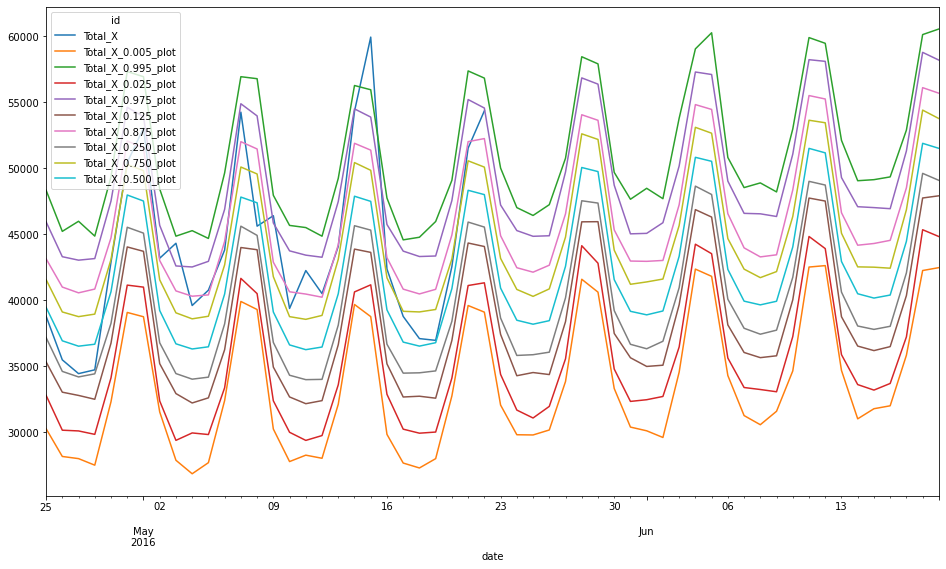

In [11]:
#### show one example

index = 0
data = sales_valid.iloc[index]
params = data, data.name, 'plot'
forecast_valid = fit_model(params)
data = sales_eval.iloc[index]
params = data, data.name, 'plot'
forecast_eval = fit_model(params)
data = pd.concat([forecast_valid, forecast_eval], axis=1)
data = pd.concat([sales_eval.iloc[index:index+1, -28:], data])
result_example = data

result_example.T.plot(figsize=(16,9))

In [15]:
### validation-data
sales_list = [(row, row.name, 'validation') for _, row in sales_valid.head(8).iterrows()] 
pool = Pool(4)
result = pool.map(fit_model, sales_list)
sub_valid = pd.concat(result)

In [14]:
### evaluation-data
sales_list = [(row, row.name, 'evaluation') for _, row in sales_eval.head(8).iterrows()] 
pool = Pool(4)
result = pool.map(fit_model, sales_list)
sub_eval = pd.concat(result)

In [16]:
sub_valid.columns = [f'F{i+1}' for i in range(28)]
sub_eval.columns = [f'F{i+1}' for i in range(28)]
submission = pd.concat([sub_valid, sub_eval])
submission.to_csv('submission.csv', float_format='%.5g')

In [15]:
submission

F1            F2            F3  \
id                                                                   
Total_X_0.005_validation  30358.695849  27814.900240  27850.235172   
Total_X_0.995_validation  48527.275804  46817.142748  45662.464462   
Total_X_0.025_validation  33298.291015  30246.333356  29748.892048   
Total_X_0.975_validation  46395.696427  43759.643045  43559.752485   
Total_X_0.125_validation  35512.521455  32914.302257  32946.467353   
...                                ...           ...           ...   
CA_4_X_0.125_evaluation    2457.131547   2277.769283   2217.241824   
CA_4_X_0.875_evaluation    2930.770395   2766.959862   2707.026219   
CA_4_X_0.250_evaluation    2565.580277   2374.709091   2317.327396   
CA_4_X_0.750_evaluation    2850.741748   2658.248905   2608.098168   
CA_4_X_0.500_evaluation    2699.259207   2521.863739   2463.539570   

                                    F4            F5            F6  \
id                                                                   
Total_X_0.005_validation  28450.877013  32241.617428  39788.010768   
Total_X_0.995_validation  45769.891724  49586.743306  56580.579701   
Total_X_0.025_validation  29838.822082  33854.026740  40969.966572   
Total_X_0.975_validation  43056.837867  47473.986398  54999.473123   
Total_X_0.125_validation  33014.524168  36906.811454  44095.578298   
...                                ...           ...           ...   
CA_4_X_0.125_evaluation    2228.254192   2360.286017   2693.986160   
CA_4_X_0.875_evaluation    2712.955116   2871.449860   3166.313135   
CA_4_X_0.250_evaluation    2336.457920   2477.806827   2792.985751   
CA_4_X_0.750_evaluation    2608.716623   2746.408994   3066.039304   
CA_4_X_0.500_evaluation    2471.569425   2617.964964   2929.591131   

                                    F7            F8            F9  \
id                                                                   
Total_X_0.005_validation  38195.252229  31647.644464  28755.908679   
Total_X_0.995_validation  56006.216555  48005.274878  45375.738446   
Total_X_0.025_validation  41040.490899  33079.002442  30216.673654   
Total_X_0.975_validation  54329.576944  46027.433294  43615.376197   
Total_X_0.125_validation  43551.187915  35006.425001  32823.053786   
...                                ...           ...           ...   
CA_4_X_0.125_evaluation    2746.986200   2461.431370   2297.747982   
CA_4_X_0.875_evaluation    3256.583418   2955.856867   2785.718519   
CA_4_X_0.250_evaluation    2862.117811   2590.125165   2396.252510   
CA_4_X_0.750_evaluation    3144.250269   2861.709042   2685.658122   
CA_4_X_0.500_evaluation    2997.716548   2719.167985   2543.177062   

                                   F10  ...           F19           F20  \
id                                      ...                               
Total_X_0.005_validation  28087.128652  ...  32182.627604  39430.735789   
Total_X_0.995_validation  45607.274482  ...  49698.247895  56541.227506   
Total_X_0.025_validation  29375.145881  ...  33651.045023  41494.160588   
Total_X_0.975_validation  42502.915613  ...  47175.557432  54562.724060   
Total_X_0.125_validation  32599.670605  ...  36549.599935  43786.830229   
...                                ...  ...           ...           ...   
CA_4_X_0.125_evaluation    2244.392500  ...   2415.703871   2725.976478   
CA_4_X_0.875_evaluation    2714.677222  ...   2890.308986   3199.430918   
CA_4_X_0.250_evaluation    2349.211705  ...   2506.413605   2834.362657   
CA_4_X_0.750_evaluation    2619.454867  ...   2788.782692   3125.362167   
CA_4_X_0.500_evaluation    2486.007771  ...   2660.430374   2970.454501   

                                   F21           F22           F23  \
id                                                                   
Total_X_0.005_validation  38548.543719  30968.772206  28373.032099   
Total_X_0.995_validation  56296.914915  47435.029205  45556.351964   
Total_X_0.025_validation  40930.330732  32125.7